### Solution for https://github.com/Automating-GIS-processes-2022/Exercise-4/blob/main/Exercise-4-problem-2.ipynb

In [235]:
import os
os.environ['USE_PYGEOS'] = '0'


from pathlib import Path
import mapclassify
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

In [236]:
NOTEBOOK_PATH = Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

### Problem 2: Calculate and visualise the dominance areas of shopping centres (10 points)

In [237]:
grid = gpd.read_file(DATA_DIRECTORY / "YKR_grid_EPSG3067.gpkg")
grid = grid.set_index("YKR_ID")
grid.head()

,geometry
YKR_ID,
5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6..."


In [244]:
ride_times = pd.DataFrame()
walk_times = pd.DataFrame()
malls = gpd.GeoDataFrame([], columns=["id", "geometry"])

# Reading all mall datasets
for filepath in DATA_DIRECTORY.glob("travel_times_to_*.txt"):
    # Extracting mall name from the path
    mall_name = filepath.stem[24:]
    # Reading mall file and filtering out rows with "-1"
    temp_df = (
        pd
            .read_csv(filepath, sep=";", usecols=["from_id", "to_id", "pt_r_t", "car_r_t"], index_col="from_id")
            .loc[lambda df: (df != -1).all(axis=1)]
    )
    # getting mall location id
    mall_id = temp_df.iloc[0]["to_id"]
    # adding mall geometry to the separate dataframe
    malls.loc[mall_name] = [mall_id, grid.loc[mall_id, "geometry"]]
    temp_df = temp_df.drop(columns=["to_id"])
    
    ride_times[mall_name] = temp_df["car_r_t"]
    walk_times[mall_name] = temp_df["pt_r_t"]

malls

,id,geometry
Iso_Omena,5978593,"POLYGON ((374500.000 6671500.000, 374250.000 6..."
Ruoholahti,5980260,"POLYGON ((384250.000 6671250.000, 384000.000 6..."
Jumbo,5878070,"POLYGON ((387500.000 6685500.000, 387250.000 6..."
Dixi,5878087,"POLYGON ((391750.000 6685500.000, 391500.000 6..."
Myyrmanni,5902043,"POLYGON ((381250.000 6682250.000, 381000.000 6..."
Forum,5975373,"POLYGON ((385500.000 6672000.000, 385250.000 6..."
Itis,5944003,"POLYGON ((394000.000 6676500.000, 393750.000 6..."


In [245]:
walk_times.head()

,Iso_Omena,Ruoholahti,Jumbo,Dixi,Myyrmanni,Forum,Itis
from_id,,,,,,,
5785640,141,118,101,102,90,110,132
5785641,143,121,108,109,93,113,135
5785642,145,123,109,111,95,115,137
5785643,149,127,114,115,99,119,141
5787544,134,111,98,99,83,103,125


In [246]:
ride_times.head()

,Iso_Omena,Ruoholahti,Jumbo,Dixi,Myyrmanni,Forum,Itis
from_id,,,,,,,
5785640,56,56,39,45,39,49,50
5785641,56,56,39,45,39,49,51
5785642,64,63,45,52,47,57,58
5785643,67,67,46,48,51,60,57
5787544,55,55,38,44,38,48,50


In [148]:
classbreaks = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

In [247]:
# getting minimum walking time to the nearest mall
grid["min_walk"] = walk_times.min(axis=1)
# getting mall with the smallest walking time
grid["min_walk_dest"] = walk_times.idxmin(axis=1)
# assigning numeric class based on walking time
grid["min_walk_class"] = grid[["min_walk"]].apply(mapclassify.UserDefined.make(bins=classbreaks))

# getting minimum riding time to the nearest mall
grid["min_ride"] = ride_times.min(axis=1)
# getting mall with the smallest riding time
grid["min_ride_dest"] = ride_times.idxmin(axis=1)
# assigning numeric class based on riding time
grid["min_ride_class"] = grid[["min_ride"]].apply(mapclassify.UserDefined.make(bins=classbreaks))

grid = grid.dropna()
grid

,geometry,min_walk,min_walk_dest,min_walk_class,min_ride,min_ride_dest,min_ride_class
YKR_ID,,,,,,,
5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",90.0,Myyrmanni,12,39.0,Jumbo,7
5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",93.0,Myyrmanni,12,39.0,Jumbo,7
5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",95.0,Myyrmanni,12,45.0,Jumbo,8
5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",99.0,Myyrmanni,12,46.0,Jumbo,9
5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",83.0,Myyrmanni,12,38.0,Jumbo,7
...,...,...,...,...,...,...,...
6016697,"POLYGON ((372750.000 6665500.000, 372500.000 6...",40.0,Iso_Omena,7,30.0,Iso_Omena,5
6016698,"POLYGON ((373000.000 6665500.000, 372750.000 6...",38.0,Iso_Omena,7,31.0,Iso_Omena,6
6016699,"POLYGON ((373250.000 6665500.000, 373000.000 6...",40.0,Iso_Omena,7,33.0,Iso_Omena,6


In [248]:
# combining the polygons for the same walking-mall-areas
min_walk_dest = grid.dissolve('min_walk_dest')
# combining the polygons for the same riding-mall-areas
min_ride_dest = grid.dissolve('min_ride_dest')

# getting centroids for mall polygons
malls_points = malls.geometry.centroid

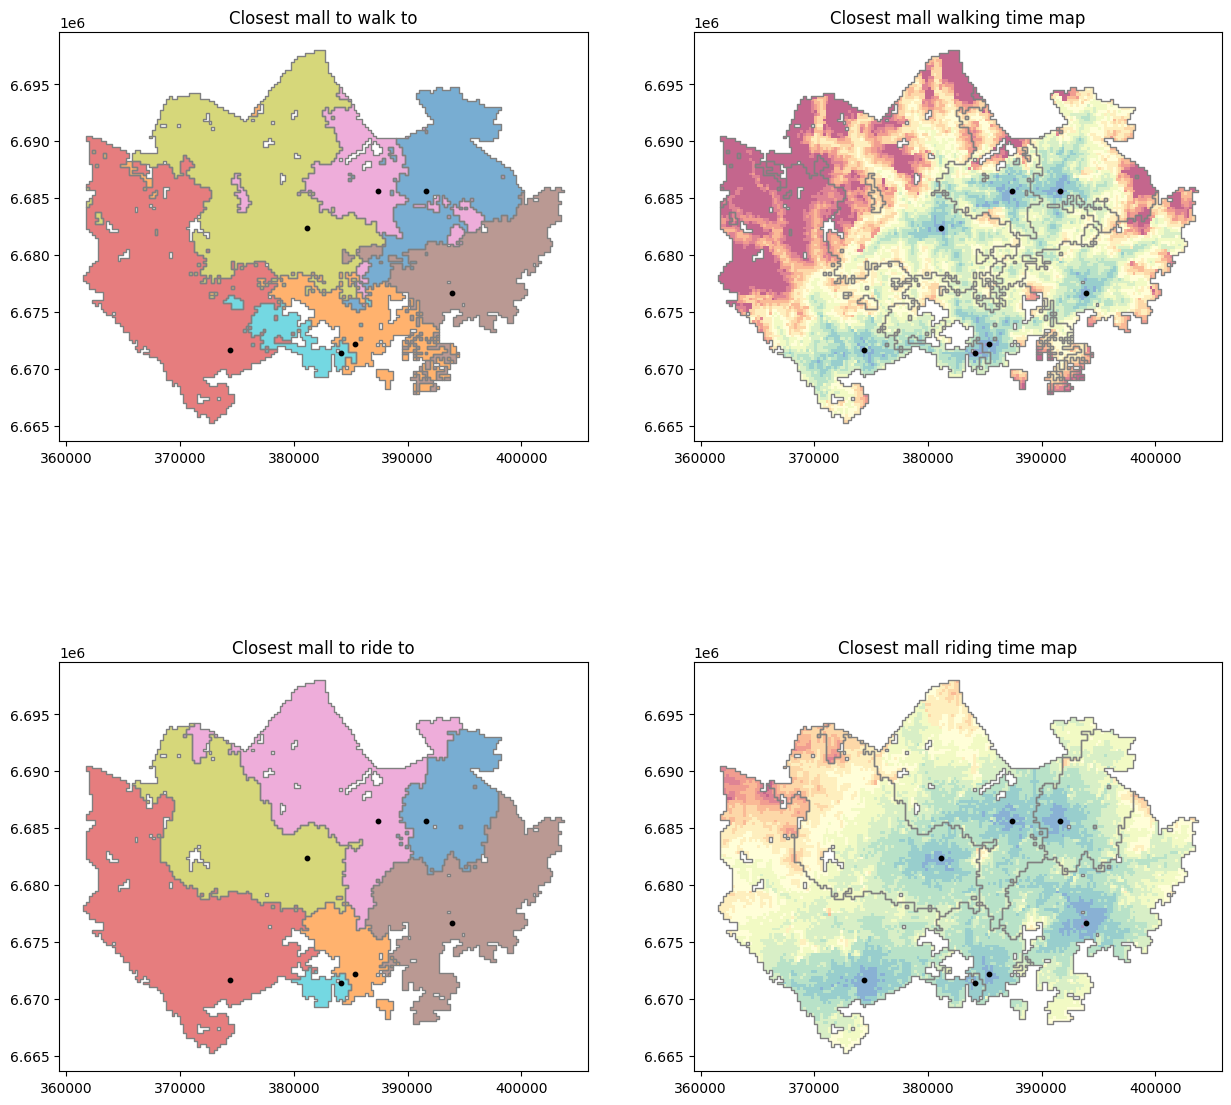

In [232]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

ax_1 = axs[0, 0]
grid.plot(column="min_walk_dest", ax=ax_1, alpha=0.6)
min_walk_dest.plot(facecolor="none", edgecolor="grey", ax=ax_1)
malls_points.plot(markersize=10, color="black", ax=ax_1)
ax_1.title.set_text('Closest mall to walk to')

ax_2 = axs[0, 1]
grid.plot(column="min_walk_class", cmap="Spectral_r", ax=ax_2, alpha=0.6)
min_walk_dest.plot(facecolor="none", edgecolor="grey", ax=ax_2)
malls_points.plot(markersize=10, color="black", ax=ax_2)
ax_2.title.set_text('Closest mall walking time map')

ax_3 = axs[1, 0]
grid.plot(column="min_ride_dest", ax=ax_3, alpha=0.6)
min_ride_dest.plot(facecolor="none", edgecolor="grey", ax=ax_3)
malls_points.plot(markersize=10, color="black", ax=ax_3)
ax_3.title.set_text('Closest mall to ride to')

ax_4 = axs[1, 1]
grid.plot(column="min_ride_class", cmap="Spectral_r", ax=ax_4, alpha=0.6)
min_ride_dest.plot(facecolor="none", edgecolor="grey", ax=ax_4)
malls_points.plot(markersize=10, color="black", ax=ax_4)
ax_4.title.set_text('Closest mall riding time map')

In [233]:
fig.savefig(DATA_DIRECTORY / "dominance_areas.png") 

In [234]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
assert (DATA_DIRECTORY / "dominance_areas.png").exists()